In [1]:
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("..")
sys.path.append("../src")
sys.path.append("../src/rna_transform")
sys.path.append("../src/qspright")

import rna_transform.utils as utils
from rna_transform.rna_helper import RNAHelper
from qspright.utils import best_convex_underestimator
from rna_transform.rna_tests import run_parallel_tests
import itertools

In [2]:
positions = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

helper = RNAHelper(positions)
n = helper.n
q = helper.q

print("n = {}, N = {}".format(n, q ** n))

n = 10, N = 1048576


## Calculate free energies of different RNA sequences

Constructs and save the data corresponding to the quasi-empirical RNA fitness function of the Hammerhead ribozyme HH9.

In [3]:
# helper.calculate_rna_data(parallel=True)

### Calculate true values of the GWHT coefficients

Calculates the GWHT transform of the RNA free energy values using vanilla FFT.

In [4]:
emp_beta_gwht = helper.compute_rna_model(method="gwht", save=False)

Found GWHT coefficients


In [5]:
# Calculate fraction of variance explained by empirical coefficients
bm_fv_gwht = utils.calc_frac_var_explained(emp_beta_gwht)

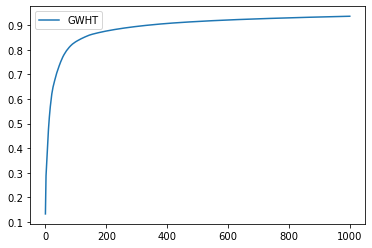

In [6]:
plt.plot(bm_fv_gwht[:1000], label = "GWHT")
plt.legend()
plt.show()

## Test QSPRIGHT with different parameters

Construct a grid of parameters. For each entry, run multiple test rounds. Compute the average for each parameter selection. 

In [12]:
iters = 1
num_subsample_list = [4, 5, 6, 7]
num_random_delays_list = [4, 6, 8, 10]
b_list = [4, 5, 6, 7]

result = run_parallel_tests(helper, iters, num_subsample_list, num_random_delays_list, b_list, emp_beta_gwht)
    
sample_ratios, unique_sample_ratios, nmses = result

100%|██████████| 64/64 [02:41<00:00,  2.53s/it]


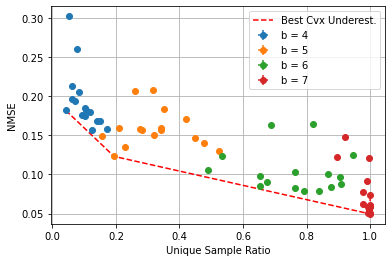

In [21]:
all_points = np.zeros(shape=[0,2])

for i, b in enumerate(b_list):
    s_values = np.mean(unique_sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(nmses[:, :, i, :], axis=-1).flatten()
    s_std = np.std(unique_sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_std =  np.std(nmses[:, :, i, :], axis=-1).flatten()

    plt.errorbar(s_values, mse_values, xerr= s_std, yerr= mse_std, label = "b = {}".format(b), fmt="o")
        
    all_points = np.concatenate((all_points, np.array([s_values, mse_values]).T), axis = 0)

bcue = best_convex_underestimator(all_points)
plt.plot(bcue[:,0], bcue[:,1], 'r--', lw=1.5, label="Best Cvx Underest.")

plt.xlabel('Unique Sample Ratio')
plt.ylabel('NMSE')
plt.legend()
plt.grid()
plt.savefig('figs/nmse-vs-unique-sample-ratio.png')
plt.show()

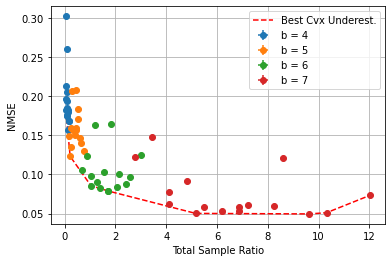

In [22]:
all_points = np.zeros(shape=[0,2])

for i, b in enumerate(b_list):
    s_values = np.mean(sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_values =  np.mean(nmses[:, :, i, :], axis=-1).flatten()
    s_std = np.std(sample_ratios[:, :, i, :], axis=-1).flatten()
    mse_std =  np.std(nmses[:, :, i, :], axis=-1).flatten()

    plt.errorbar(s_values, mse_values, xerr= s_std, yerr= mse_std, label = "b = {}".format(b), fmt="o")

    all_points = np.concatenate((all_points, np.array([s_values, mse_values]).T), axis = 0)

bcue = best_convex_underestimator(all_points)
plt.plot(bcue[:,0], bcue[:,1], 'r--', lw=1.5, label="Best Cvx Underest.")

plt.xlabel('Total Sample Ratio')
plt.ylabel('NMSE')
plt.legend()
plt.grid()
plt.savefig('figs/nmse-vs-total-sample-ratio.png')
plt.show()